In [1]:
!kaggle datasets download datamunge/sign-language-mnist
!unzip -od dataset sign-language-mnist.zip

Dataset URL: https://www.kaggle.com/datasets/datamunge/sign-language-mnist
License(s): CC0-1.0
sign-language-mnist.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sign-language-mnist.zip
  inflating: dataset/amer_sign2.png  
  inflating: dataset/amer_sign3.png  
  inflating: dataset/american_sign_language.PNG  
  inflating: dataset/sign_mnist_test.csv  
  inflating: dataset/sign_mnist_test/sign_mnist_test.csv  
  inflating: dataset/sign_mnist_train.csv  
  inflating: dataset/sign_mnist_train/sign_mnist_train.csv  


In [2]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from model import ConvNet
from torchvision.utils import make_grid
from torch import nn, optim
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def to_tensor(df):
    return torch.from_numpy(df.to_numpy())

def to_dataloader(x, y):
    ts = TensorDataset(x, y)
    return DataLoader(ts, batch_size=64)

/var/folders/lq/4jp2ndl57996typyw791t0x00000gn/T/ipykernel_53042/918001507.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


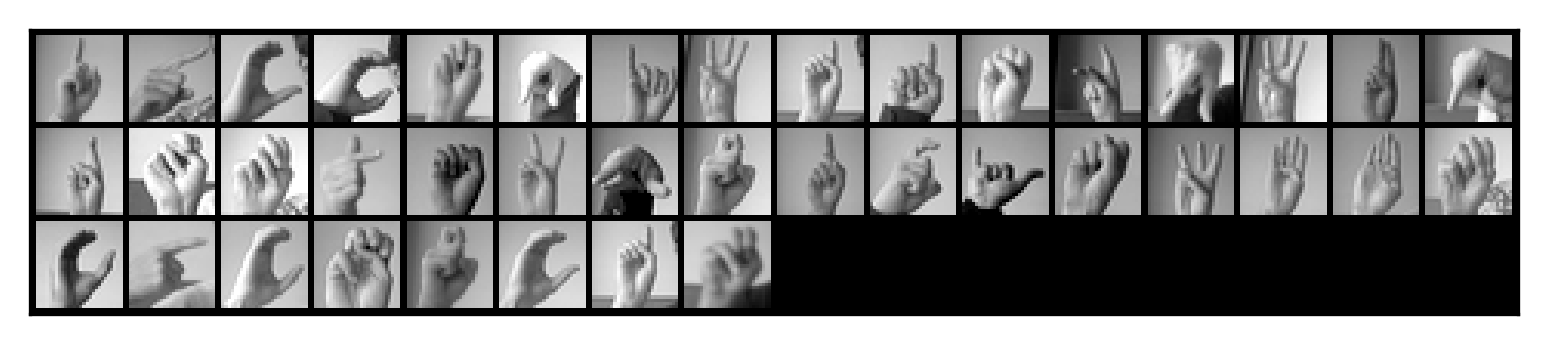

In [5]:
train_df = pd.read_csv('dataset/sign_mnist_train.csv')
test_df = pd.read_csv('dataset/sign_mnist_test.csv')

train_labels = to_tensor(train_df['label'])
train_images = to_tensor(train_df[train_df.columns[1:]])

test_labels = to_tensor(test_df['label'])
test_images = to_tensor(test_df[test_df.columns[1:]])

train_dataloader = to_dataloader(train_images, train_labels)

test_dataloader = to_dataloader(test_images, test_labels)

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
images = images.reshape(64, 1, 28, 28)
images = images[:40, :, :, :]  # selecting a subset of images

# display grid
import numpy as np
import matplotlib.pyplot as plt



grid = make_grid(images, nrow=16)
grid = grid.numpy()

fig, ax = plt.subplots(dpi=300)
ax.imshow(np.transpose(grid, (1, 2, 0)))
ax.set_xticks([])
ax.set_yticks([])
fig.show()
fig.savefig('plots/data-grid.pdf', dpi=300)


In [6]:
@torch.no_grad()
def get_accuracy(net, loader, device):
    total = 0
    correct = 0
    for data in loader:
        images, labels = data
        images = images.reshape(-1, 1, 28, 28).float()
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return correct / total

def train_net(net, trainloader, testloader, epochs=50,
              criterion=nn.CrossEntropyLoss(), lr=0.001):
    
    # Automatically determine device (MPS if available on Mac, otherwise CPU)
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    net.to(device) 
    
    optimizer = optim.Adam(net.parameters(), lr=lr)
    training_loss = []
    training_acc = []
    testing_acc = []
    epoch_list = list(range(1, epochs + 1))
    best = 0.0
    
    for epoch in epoch_list:
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs = inputs.reshape(-1, 1, 28, 28).float()
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        training_loss.append(running_loss / i)
        training_acc.append(get_accuracy(net, trainloader, device))
        testing_acc.append(get_accuracy(net, testloader, device))
        print("Epoch %s: loss: %.2f | train_acc: %.2f | test_acc: %.2f" % 
              (epoch, training_loss[-1], training_acc[-1], testing_acc[-1]), end='\r')

    print("\nTraining complete")
    return dict(net=net, 
                epochs=epoch_list, 
                training_loss=training_loss, 
                training_acc=training_acc, 
                testing_acc=testing_acc)


In [7]:
model = ConvNet()
outputs = train_net(model, train_dataloader, test_dataloader, epochs=50)

Epoch 50: loss: 2.37 | train_acc: 0.96 | test_acc: 0.84
Training complete


In [8]:
torch.save(model.state_dict(), 'model.weights')

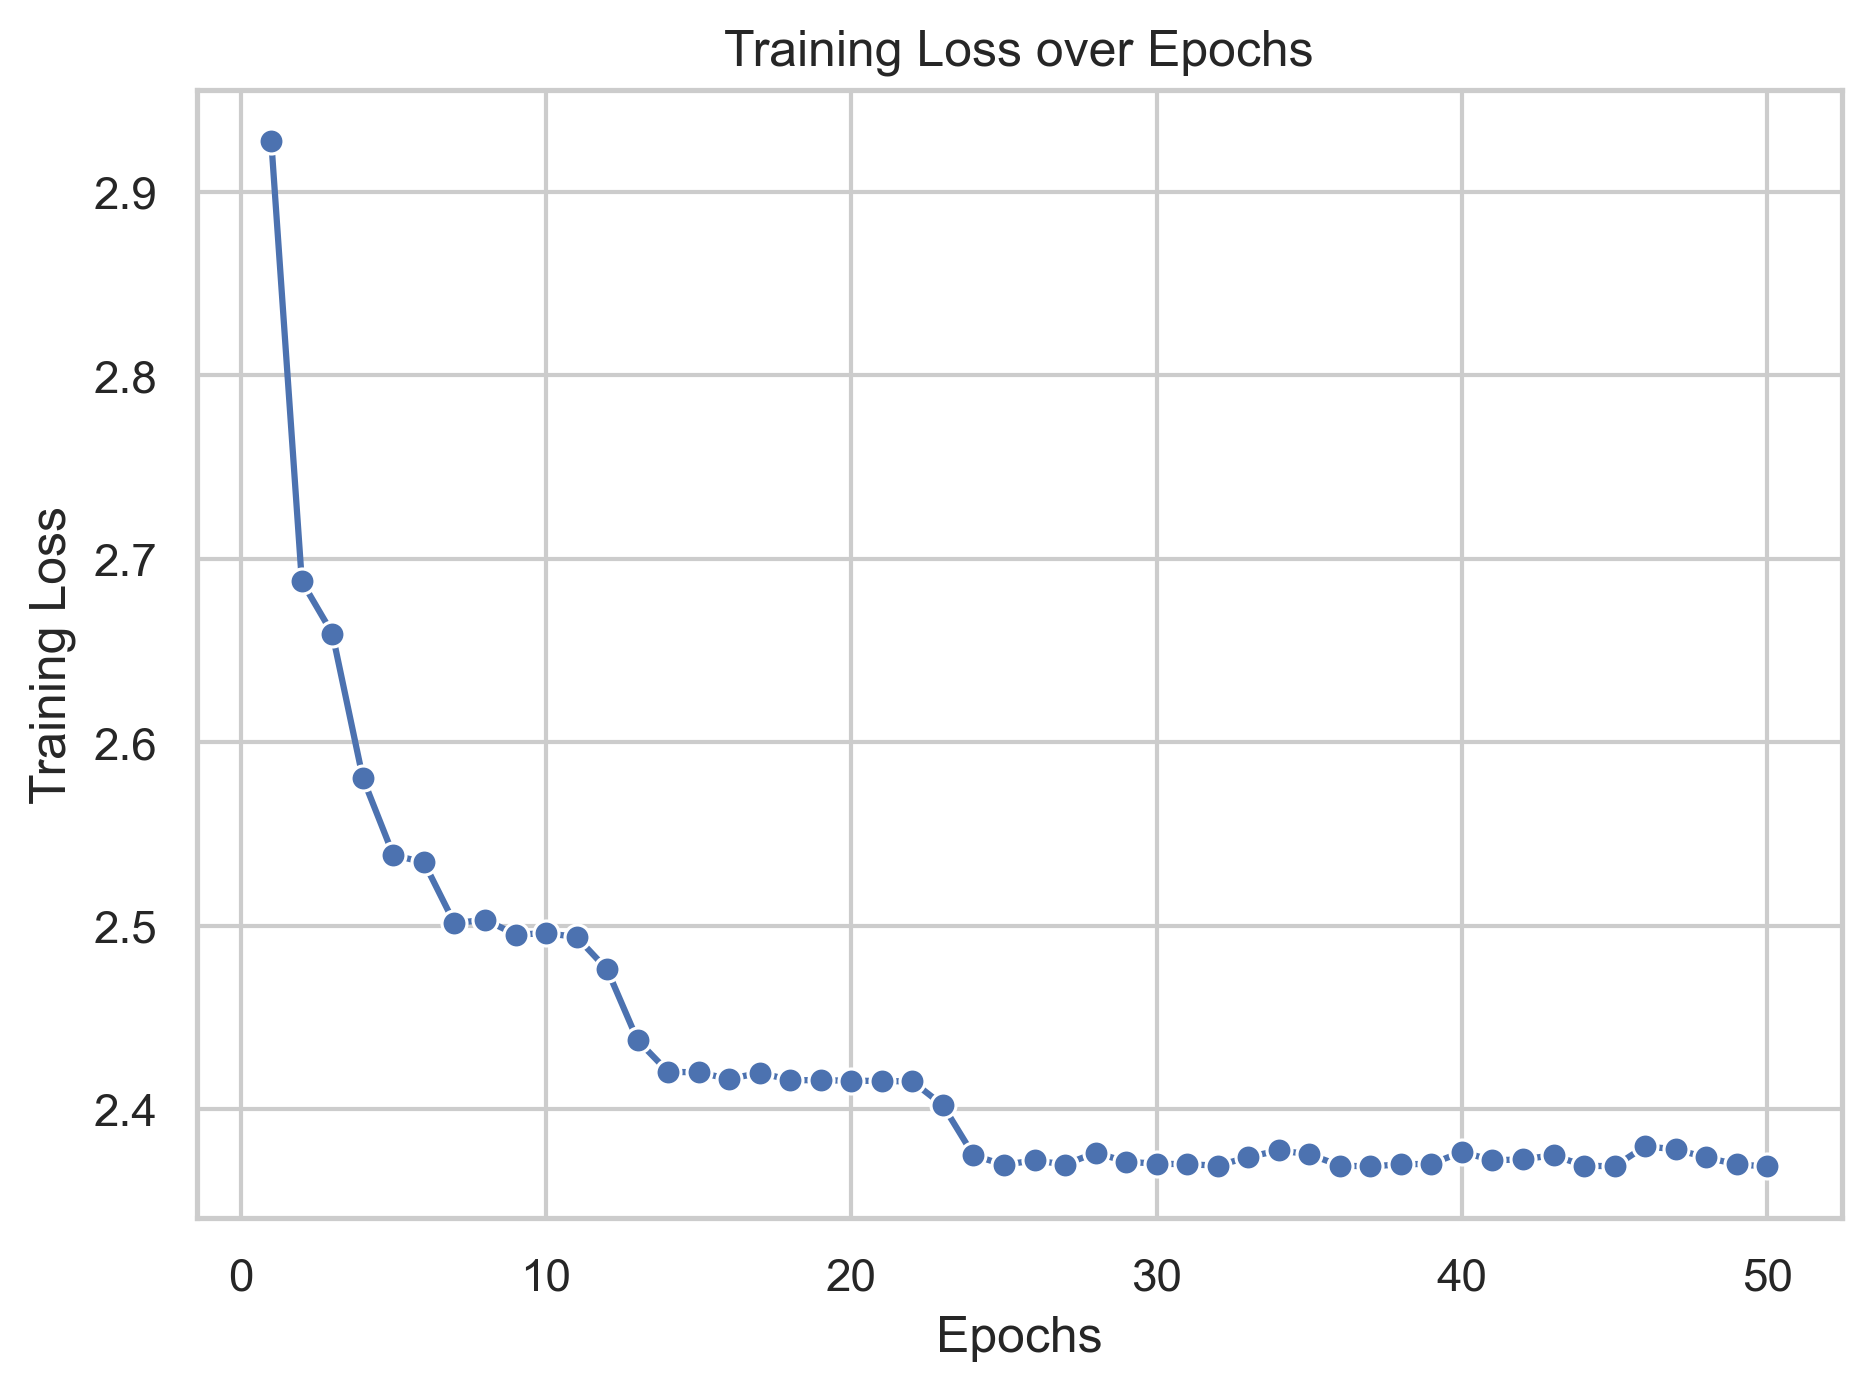

In [9]:
sns.set(style='whitegrid')

fig, ax = plt.subplots(dpi=300)

sns.lineplot(x=outputs['epochs'], y=outputs['training_loss'], ax=ax, marker='o', color='b')

ax.set_xlabel('Epochs')
ax.set_ylabel('Training Loss')
ax.set_title('Training Loss over Epochs')

fig.tight_layout()
fig.savefig('plots/loss.pdf', dpi=300)

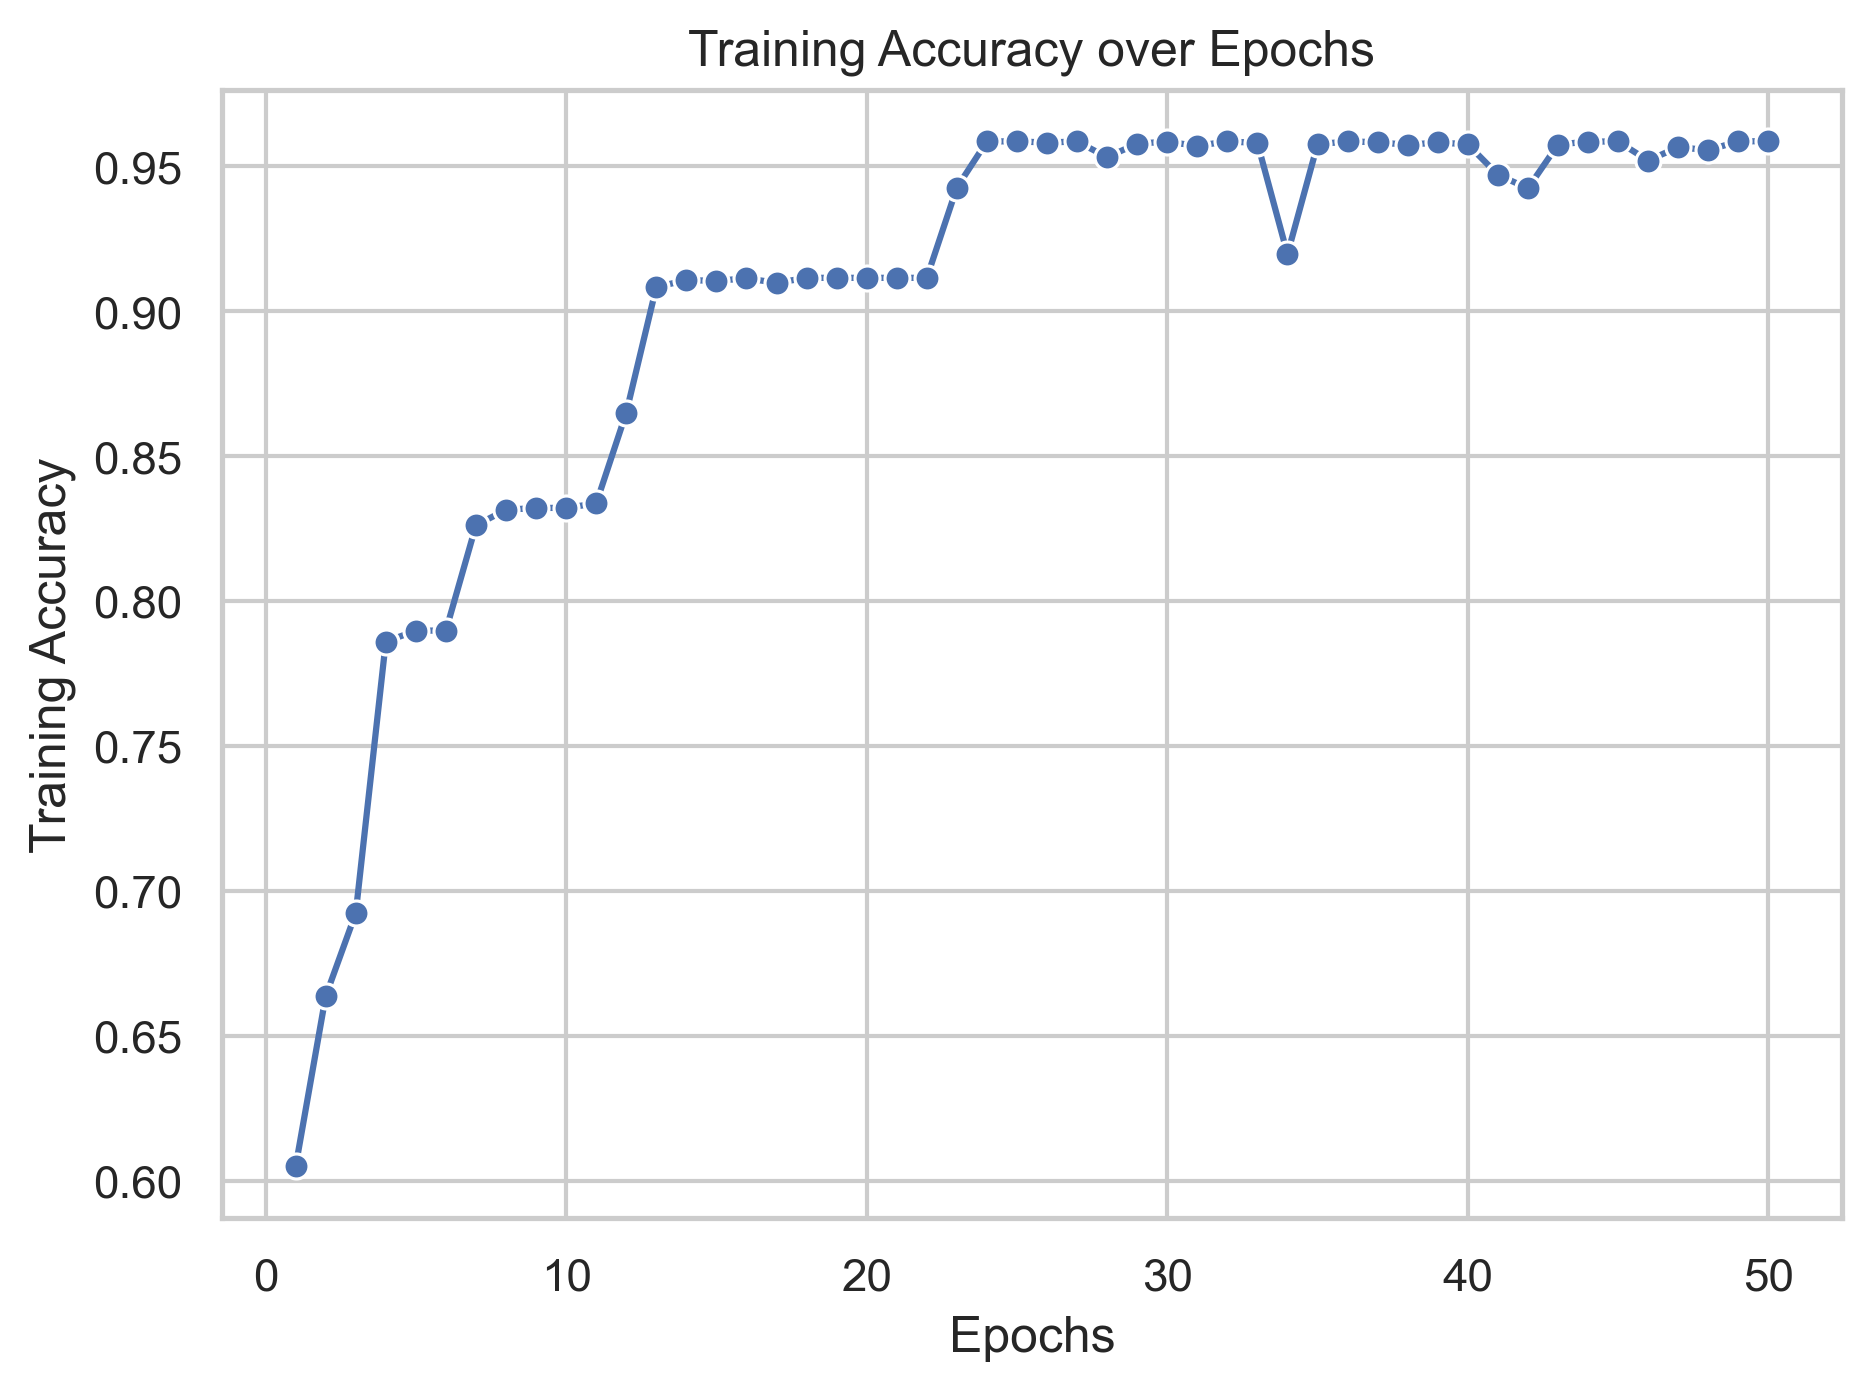

In [10]:
sns.set(style='whitegrid')

fig, ax = plt.subplots(dpi=300)

sns.lineplot(x=outputs['epochs'], y=outputs['training_acc'], ax=ax, marker='o', color='b')

ax.set_xlabel('Epochs')
ax.set_ylabel('Training Accuracy')
ax.set_title('Training Accuracy over Epochs')

fig.tight_layout()
fig.savefig('plots/train-acc.pdf', dpi=300)


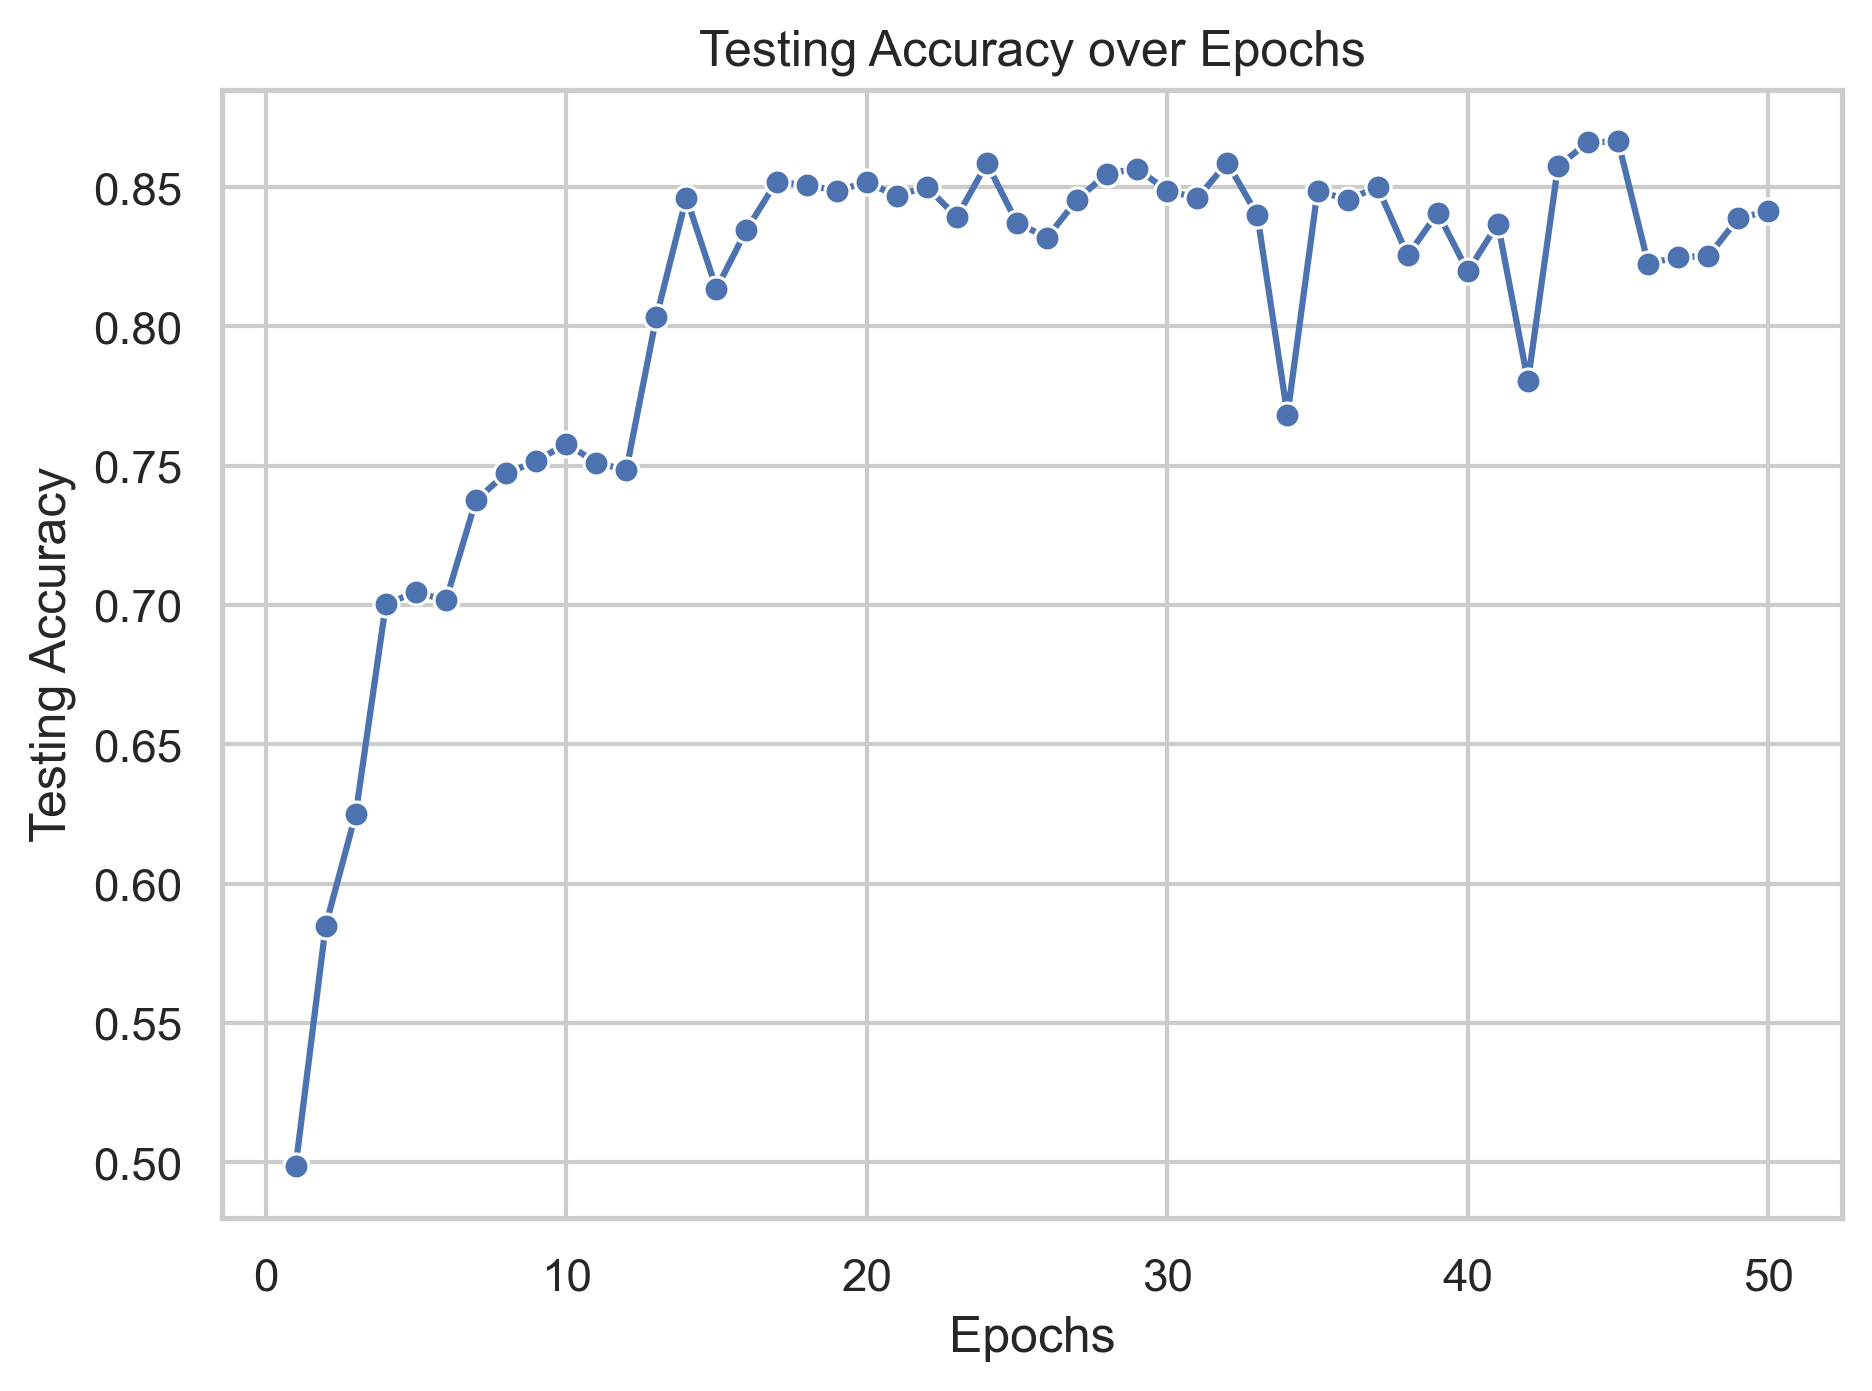

In [11]:

sns.set(style='whitegrid')

fig, ax = plt.subplots(dpi=300)

sns.lineplot(x=outputs['epochs'], y=outputs['testing_acc'], ax=ax, marker='o', color='b')

ax.set_xlabel('Epochs')
ax.set_ylabel('Testing Accuracy')
ax.set_title('Testing Accuracy over Epochs')

fig.tight_layout()
fig.savefig('plots/test-acc.pdf', dpi=300)
